<a href="https://colab.research.google.com/github/murarosilva/Digital_CE/blob/main/CE_studies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [ ]:
!pip install igraph
!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.5 MB/s eta 0:00:00


In [ ]:
from igraph import Graph
import igraph as ig
import pandas as pd
import leidenalg as la
import numpy as np
import pandas_gbq
import glob
import matplotlib.pyplot as plt

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
folder = '/content/drive/My Drive/[1] Lund University/[1] Research Projects/[1] CE and AI/'

# Collect works

## Original set of works - Circular Economy and Digitalization

In [ ]:
%%bigquery --project insyspo

DROP TABLE IF EXISTS insyspo.userdb_vinicius_muraro.ce_digi_works;
CREATE TABLE insyspo.userdb_vinicius_muraro.ce_digi_works AS (
  SELECT DISTINCT id
  FROM (
    SELECT id
    FROM insyspo.publicdb_openalex_2024_02_rm.works
    WHERE (LOWER(display_name) LIKE '%circular economy%'
      OR LOWER(display_name) LIKE '%circular value chain%'
      OR LOWER(display_name) LIKE '%circularity%'
      OR LOWER(display_name) LIKE '%shared economy%'
      OR LOWER(display_name) LIKE '%zero waste%')
      AND (LOWER(display_name) LIKE '%digitization%'
      OR LOWER(display_name) LIKE '%digitisation%'
      OR LOWER(display_name) LIKE '%digitalization%'
      OR LOWER(display_name) LIKE '%digitalisation%'
      OR LOWER(display_name) LIKE '%digital technolog%'
      OR LOWER(display_name) LIKE '%industry 4.0%'
      OR LOWER(display_name) LIKE '%artificial intelligence%')
    UNION ALL
    SELECT id
    FROM insyspo.projectdb_cwts_summer_school_2023.works_abstracts
    WHERE (LOWER(abstract) LIKE '%circular economy%'
      OR LOWER(abstract) LIKE '%circular value chain%'
      OR LOWER(abstract) LIKE '%circularity%'
      OR LOWER(abstract) LIKE '%shared economy%'
      OR LOWER(abstract) LIKE '%zero waste%')
      AND (LOWER(abstract) LIKE '%digitisation%'
      OR LOWER(abstract) LIKE '%digitization%'
      OR LOWER(abstract) LIKE '%digitalisation%'
      OR LOWER(abstract) LIKE '%digitalization%'
      OR LOWER(abstract) LIKE '%digital technolog%'
      OR LOWER(abstract) LIKE '%industry 4.0%'
      OR LOWER(abstract) LIKE '%artificial intelligence%')
  )
)

Query is running:   0%|          |

""


# Collect citations

In [ ]:
%%bigquery --project insyspo

DROP TABLE IF EXISTS insyspo.userdb_vinicius_muraro.ce_digi_cited;
CREATE TABLE insyspo.userdb_vinicius_muraro.ce_digi_cited AS (
  SELECT  b.work_id, b.referenced_work_id
  FROM `insyspo.userdb_vinicius_muraro.ce_digi_works` AS a
  JOIN `insyspo.publicdb_openalex_2024_02_rm.works_referenced_works` AS b
  ON a.id = b.referenced_work_id
);

DROP TABLE IF EXISTS insyspo.userdb_vinicius_muraro.ce_digi_citing;
CREATE TABLE insyspo.userdb_vinicius_muraro.ce_digi_citing AS (
  SELECT  b.work_id, b.referenced_work_id
  FROM `insyspo.userdb_vinicius_muraro.ce_digi_works` AS a
  JOIN `insyspo.publicdb_openalex_2024_02_rm.works_referenced_works` AS b
  ON a.id = b.work_id
);


Query is running:   0%|          |

""


## Works that cited original set that are also in the original set

In [ ]:
%%bigquery digi_cited --project insyspo

SELECT a.work_id, COUNT(*) AS n
FROM insyspo.userdb_vinicius_muraro.ce_digi_cited AS a
JOIN insyspo.userdb_vinicius_muraro.ce_digi_works AS b
ON a.work_id = b.id
GROUP BY a.work_id

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
digi_cited.sort_values(by='n', ascending=False)

,work_id,n
123,https://openalex.org/W4322155000,54
124,https://openalex.org/W4380624629,38
14,https://openalex.org/W4294573115,37
16,https://openalex.org/W3156696534,31
80,https://openalex.org/W4213413300,29
...,...,...
176,https://openalex.org/W3216627349,1
177,https://openalex.org/W3134388662,1
196,https://openalex.org/W3016494077,1
200,https://openalex.org/W3181788064,1


## Works cited by original set that are also in the original set

In [ ]:
%%bigquery digi_citing --project insyspo

SELECT a.referenced_work_id, COUNT(*) AS n
FROM insyspo.userdb_vinicius_muraro.ce_digi_citing AS a
JOIN insyspo.userdb_vinicius_muraro.ce_digi_works AS b
ON a.referenced_work_id = b.id
GROUP BY a.referenced_work_id

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
digi_citing.sort_values(by='n', ascending=False)

,referenced_work_id,n
3,https://openalex.org/W2791930516,83
16,https://openalex.org/W2988226881,77
7,https://openalex.org/W2947011708,74
9,https://openalex.org/W2902970703,63
1,https://openalex.org/W2793838027,50
...,...,...
36,https://openalex.org/W2810260586,1
139,https://openalex.org/W4214560018,1
143,https://openalex.org/W3159193233,1
144,https://openalex.org/W4297830616,1


## Complete set of connections

In [ ]:
%%bigquery --project insyspo

DROP TABLE IF EXISTS insyspo.userdb_vinicius_muraro.ce_digi_citations;
CREATE TABLE insyspo.userdb_vinicius_muraro.ce_digi_citations AS (
  SELECT  *
  FROM `insyspo.userdb_vinicius_muraro.ce_digi_cited`
  UNION ALL
  SELECT  *
  FROM `insyspo.userdb_vinicius_muraro.ce_digi_citing`
);


Query is running:   0%|          |

""


# Clustering

In [ ]:
%%bigquery df --project=insyspo

SELECT *,
FROM insyspo.userdb_vinicius_muraro.ce_digi_citations

Query is running:   0%|          |

Downloading:   0%|          |

## Clustering with Leiden algorithm

In [ ]:
tuples = [tuple(x) for x in df.values]
G = ig.Graph.TupleList(tuples, directed = True)

In [ ]:
#partition = la.find_partition(G, la.CPMVertexPartition, resolution_parameter = 1e-4)
partition = la.find_partition(G, la.ModularityVertexPartition)

In [ ]:
partition.summary()

'Clustering with 15743 elements and 61 clusters'

In [ ]:
#partition.sizes()

(array([ 8.,  4.,  1.,  0.,  3.,  1.,  2.,  0.,  1.,  1.,  1.,  3.,  4.,
         2.,  4.,  4., 13.,  4.,  4.,  1.]),
 array([0.69314718, 1.01672584, 1.3403045 , 1.66388316, 1.98746182,
        2.31104048, 2.63461914, 2.9581978 , 3.28177646, 3.60535512,
        3.92893378, 4.25251244, 4.5760911 , 4.89966976, 5.22324842,
        5.54682708, 5.87040574, 6.1939844 , 6.51756306, 6.84114172,
        7.16472038]),
 <BarContainer object of 20 artists>)

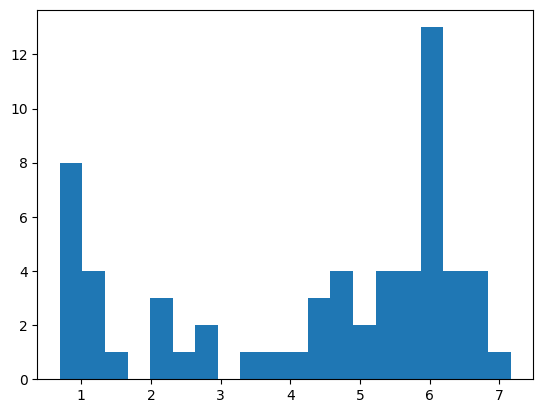

In [ ]:
plt.hist(np.log(partition.sizes()),bins=20)


## Save clustering to table

In [ ]:
%%bigquery ce_digi_works --project insyspo

SELECT *
FROM insyspo.userdb_vinicius_muraro.ce_digi_works

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
primary_set = set(ce_digi_works['id'])
is_primary = [paper in primary_set for paper in G.vs['name']]

In [ ]:
clusters_table = pd.DataFrame({'work': G.vs['name'],'cluster': partition.membership, 'centrality': G.eigenvector_centrality(), 'isprimary': is_primary})

In [ ]:
clusters_table.to_gbq('userdb_vinicius_muraro.ce_digi_clusters', project_id='insyspo', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 703.51it/s]


In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS insyspo.userdb_vinicius_muraro.ce_digi_cluster_sizes;
CREATE TABLE insyspo.userdb_vinicius_muraro.ce_digi_cluster_sizes AS (
  SELECT cluster,
    COUNT(DISTINCT a.work) AS n_works,
    SUM(c.cited_by_count) AS citations,
    AVG(c.cited_by_count) AS avg_citations,
    AVG(c.publication_year) AS avg_year,
    MIN(c.publication_year) AS min_year,
    MAX(c.publication_year) AS max_year,
    SUM(CASE WHEN a.isprimary THEN 1 ELSE 0 END) AS primary_count
  FROM insyspo.userdb_vinicius_muraro.ce_digi_clusters AS a
  JOIN `insyspo.publicdb_openalex_2024_02_rm.works` AS c
  ON a.work = c.id
  GROUP BY cluster
)

Query is running:   0%|          |

Selecting just clusters with at least 10 papers from original set

In [ ]:
 %%bigquery --project=insyspo

DROP TABLE IF EXISTS insyspo.userdb_vinicius_muraro.ce_digi_selected_clusters;
CREATE TABLE insyspo.userdb_vinicius_muraro.ce_digi_selected_clusters AS (
  SELECT a.cluster, COUNT(DISTINCT a.work) AS size,
  STRING_AGG(CASE WHEN a.isprimary THEN b.title ELSE NULL END, '. ') AS primary_titles,  -- Conditional aggregation for titles
  SUM(CASE WHEN a.isprimary THEN 1 ELSE 0 END) AS primary_count
  FROM insyspo.userdb_vinicius_muraro.ce_digi_clusters AS a
  JOIN insyspo.publicdb_openalex_2024_02_rm.works AS b
  ON a.work = b.id
  GROUP BY cluster
  HAVING primary_count > 9
)

Query is running:   0%|          |

""


In [ ]:
 %%bigquery df --project=insyspo
 SELECT *
 FROM insyspo.userdb_vinicius_muraro.ce_digi_selected_clusters

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df['%'] = df['primary_count']/df['size']
df.sort_values('cluster')

,cluster,size,primary_titles,primary_count,%
11,0,1293,Digital Technologies and Circular Value Chains...,43,0.033256
6,1,883,"Digitalization, circular economy and the futur...",13,0.014723
7,2,868,Digital technologies and circular economy in s...,14,0.016129
9,3,834,Barriers to the adoption of digital technologi...,15,0.017986
10,6,546,Industry 4.0 to Accelerate the Circular Econom...,15,0.027473
0,7,533,Circular economy meets industry 4.0: Can big d...,10,0.018762
4,11,478,‘Better together’: Evidence on the joint adopt...,11,0.023013
2,12,452,Digitalization in the Textile Sector for Circu...,10,0.022124
5,14,443,Total productive maintenance and Industry 4.0 ...,13,0.029345
1,16,436,A quantitative framework for Industry 4.0 enab...,10,0.022936


<Axes: xlabel='cluster'>

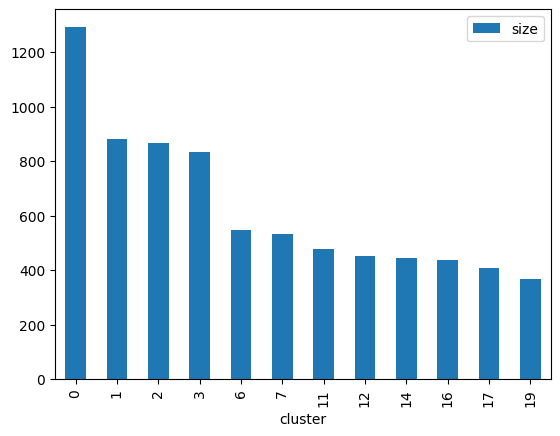

In [ ]:
df.sort_values('size',ascending=False).plot.bar(x='cluster',y='size')

## Collection information about clusters

In [ ]:
%%bigquery selected_clusters --project=insyspo

SELECT a.cluster AS cluster,
  AVG(c.publication_year) AS avg_year,
  MIN(c.publication_year) AS min_year,
  MAX(c.publication_year) AS max_year,
  COUNT(*) AS works,
  MAX(d.primary_count) AS primary_count,
  STRING_AGG(c.display_name) AS titles,
FROM insyspo.userdb_vinicius_muraro.ce_digi_clusters AS a
JOIN `insyspo.publicdb_openalex_2024_02_rm.works` AS c
ON a.work = c.id
JOIN insyspo.userdb_vinicius_muraro.ce_digi_selected_clusters AS d
ON d.cluster = a.cluster
GROUP BY a.cluster
ORDER BY a.cluster


Query is running:   0%|          |

Downloading:   0%|          |

## Age of clusters

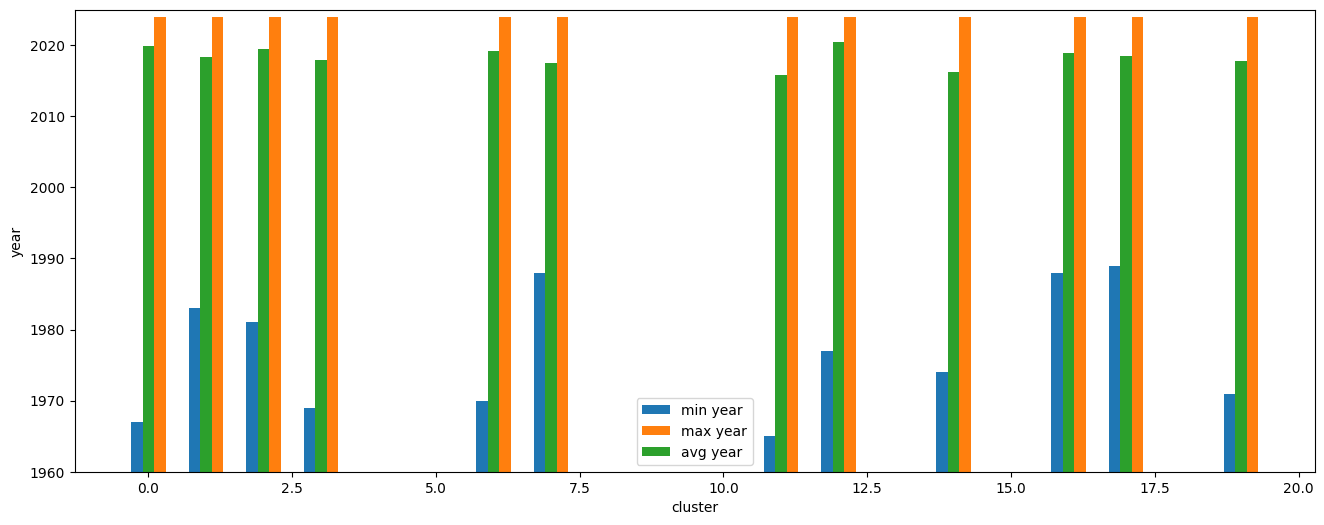

In [ ]:
plt.figure(figsize=(16,6))
plt.bar(x=df['cluster']-0.2,height=df['min_year'],width=0.2,label='min year')
plt.bar(x=df['cluster']+0.2,height=df['max_year'],width=0.2,label='max year')
plt.bar(x=df['cluster'],height=df['avg_year'],width=0.2,label='avg year')
plt.ylim((1960,2025))
plt.xlabel('cluster')
plt.ylabel('year')
plt.legend()

# Most cited works in largest clusters

In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS insyspo.userdb_vinicius_muraro.ce_digi_most_relevant_each_cluster;
CREATE TABLE insyspo.userdb_vinicius_muraro.ce_digi_most_relevant_each_cluster AS (
  SELECT cluster,
    title,
    work,
    cited_by_count,
    centrality,
    cit_order,
    central_order,
    isprimary
  FROM (
    SELECT a.cluster AS cluster,
      c.display_name AS title,
      c.cited_by_count,
      a.work,
      a.centrality,
      a.isprimary,
      ROW_NUMBER() OVER (PARTITION BY a.cluster ORDER BY c.cited_by_count DESC)
        AS cit_order,
      ROW_NUMBER() OVER (PARTITION BY a.cluster ORDER BY a.centrality DESC)
        AS central_order,
    FROM insyspo.userdb_vinicius_muraro.ce_digi_clusters AS a
    JOIN `insyspo.publicdb_openalex_2024_02_rm.works` AS c
    ON a.work = c.id
    ORDER BY cluster, c.cited_by_count DESC, a.centrality DESC
  )
  WHERE cit_order < 100 AND central_order < 100
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS insyspo.userdb_vinicius_muraro.ce_digi_most_relevant_cluster_info;
CREATE TABLE insyspo.userdb_vinicius_muraro.ce_digi_most_relevant_cluster_info AS (
  SELECT a.cluster,
    STRING_AGG(a.title,'. ') AS titles,
    SUM(a.cited_by_count) AS relevant_citations,
    AVG(a.cited_by_count) AS relevant_avg_citations,
    b.n_works,
    b.citations,
    b.avg_citations,
    COUNT(*) AS n_most_relevant,
    COUNT(CASE WHEN isprimary THEN 1 ELSE NULL END) AS primary_count
  FROM  insyspo.userdb_vinicius_muraro.ce_digi_most_relevant_each_cluster AS a
  JOIN insyspo.userdb_vinicius_muraro.ce_digi_cluster_sizes AS b
  ON a.cluster = b.cluster
  GROUP BY a.cluster, b.n_works, b.citations, b.avg_citations
  ORDER BY a.cluster
)

Query is running:   0%|          |

In [ ]:
%%bigquery cluster_info --project=insyspo
SELECT *
FROM insyspo.userdb_vinicius_muraro.ce_digi_most_relevant_cluster_info

Query is running:   0%|          |

Downloading:   0%|          |

# List of descriptions produced by LLM - GPT-4

They were produced using GPT-4 model using the titles collected for the instersection of the 100 works most cited and the 100 works most central. NOT IN USE

In [ ]:
'''themes = ["Innovative Business Models and Sustainable Practices in the Circular Economy",
          "Sustainability Integration in Industry 4.0 and Supply Chain Management",
          "Sustainable Business Practices and Technological Integration in Global Supply Chains",
          "Technological Innovations and Sustainability: Integrating AI, Circular Economy, and Environmental Management",
          "Advancements in Methodological Approaches and Sustainable Business Practices",
          "Integrating Industry 4.0 and IoT in Sustainable and Circular Economy Practices",
          "Technological Advancements and Sustainability Integration in Global Industries",
          "Industry 4.0 and Sustainable Manufacturing: Emerging Technologies and Circular Economy Integration",
          "Sustainable Manufacturing and Industry 4.0: Methodological Innovations and Applications"
          ]

They were produced using GPT-4 model using the titles collected for works belonging to the primary dataset in each cluster. PS: cluster with more than 9 primary papers

In [ ]:
themes3 = [
    "Digital Circular Economy",
    "Sustainable Manufacturing",
    "Circular Technology Practices",
    "Circular Supply Chain",
    "Digital Circular Challenges",
    "Circular Climate Mitigation",
    "Circular Supply Sustainability",
    "AI in Circular Economy",
    "Lean Circular Manufacturing",
    "Circular Manufacturing Paradigm",
    "Integrated Circular Technologies",
    "AI-Driven Circular Sustainability"
]

In [ ]:
selected_clusters['themes'] = themes3

In [ ]:
%%bigquery cluster_sizes --project=insyspo
SELECT *
FROM insyspo.userdb_vinicius_muraro.ce_digi_cluster_sizes

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
selected_clusters = selected_clusters.merge(cluster_sizes[['cluster','citations', 'avg_citations']],on='cluster',how='inner')

In [ ]:
selected_clusters.to_excel(folder+'selected_clusters.xlsx', sheet_name='Sheet1', index=False)

# Production of clusters

In [ ]:
%%bigquery  --project=insyspo

DROP TABLE IF EXISTS insyspo.userdb_vinicius_muraro.ce_digi_yearly_output;
CREATE TABLE insyspo.userdb_vinicius_muraro.ce_digi_yearly_output AS (
  SELECT c.publication_year, COUNT(a.work) AS works
  FROM insyspo.userdb_vinicius_muraro.ce_digi_clusters AS a
  JOIN `insyspo.publicdb_openalex_2024_02_rm.works` AS c
  ON a.work = c.id
  GROUP BY c.publication_year
  ORDER BY c.publication_year
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery  --project=insyspo

DROP TABLE IF EXISTS insyspo.userdb_vinicius_muraro.ce_digi_clusters_yearly;
CREATE TABLE insyspo.userdb_vinicius_muraro.ce_digi_clusters_yearly AS (
  SELECT c.publication_year,
    a.cluster,
    COUNT(a.work) AS works
  FROM insyspo.userdb_vinicius_muraro.ce_digi_clusters AS a
  JOIN `insyspo.publicdb_openalex_2024_02_rm.works` AS c
  ON a.work = c.id
  JOIN insyspo.userdb_vinicius_muraro.ce_digi_selected_clusters AS d
  ON d.cluster = a.cluster
  WHERE publication_year > 2000 AND publication_year < 2023
  GROUP BY a.cluster, c.publication_year
  ORDER BY c.publication_year, a.cluster
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery df --project=insyspo

SELECT *
FROM insyspo.userdb_vinicius_muraro.ce_digi_clusters_yearly


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
table = pd.pivot_table(df, values='works', index=['publication_year'],
                       columns=['cluster'], aggfunc="sum",fill_value=0)

<Axes: xlabel='publication_year'>

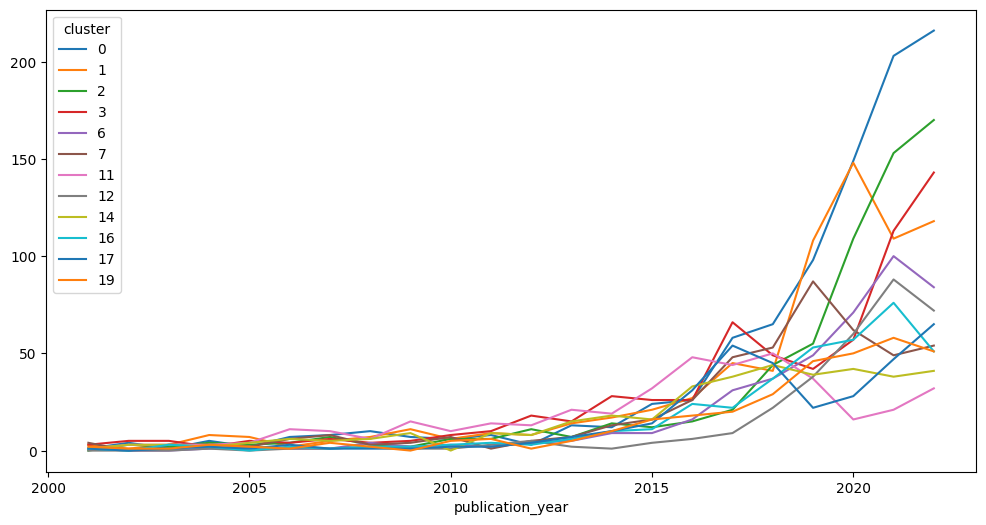

In [ ]:
table.plot.line(figsize=(12,6))

In [ ]:
%%bigquery df --project=insyspo

SELECT a.publication_year, a.cluster, a.works/b.works AS production
FROM insyspo.userdb_vinicius_muraro.ce_digi_clusters_yearly AS a
JOIN insyspo.userdb_vinicius_muraro.ce_digi_yearly_output AS b
ON a.publication_year = b.publication_year
WHERE cluster < 15

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
table = pd.pivot_table(df, values='production', index=['publication_year'],
                       columns=['cluster'], aggfunc="sum",fill_value=0)

<Axes: xlabel='publication_year'>

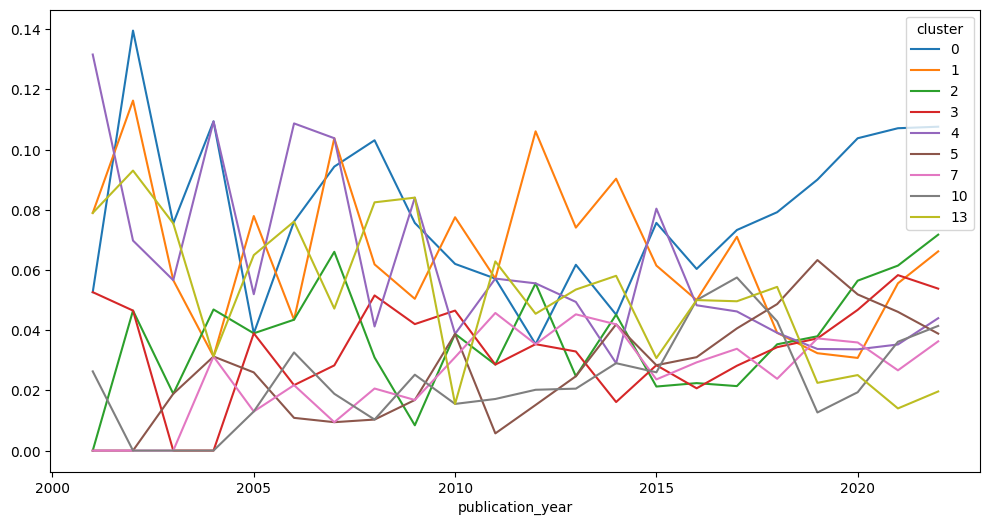

In [ ]:

table.plot.line(figsize=(12,6))

# Network of clusters

In [ ]:
%%bigquery df --project=insyspo

SELECT b.cluster AS cluster1,
  c.cluster AS cluster2,
  COUNT(*) AS n
FROM insyspo.userdb_vinicius_muraro.ce_digi_citations AS a
JOIN insyspo.userdb_vinicius_muraro.ce_digi_clusters AS b
ON a.work_id = b.work
JOIN insyspo.userdb_vinicius_muraro.ce_digi_clusters AS c
ON a.referenced_work_id = c.work
GROUP BY b.cluster, c.cluster
ORDER BY n DESC


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.head()

,cluster1,cluster2,n
0,0,0,2245
1,2,2,1122
2,3,3,1069
3,4,4,1003
4,1,1,991


In [ ]:
df.to_csv(folder+'network_clusters.csv',header=None,index=False)